# Assignment 4: Convolutional Neural Network on FashionMNIST

## Overview
In this notebook, we will build, train, and evaluate a CNN to classify images from the FashionMNIST dataset.
We will use **PyTorch** for building the model and **Torchvision** for data handling.


In [36]:
# --- Core PyTorch Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# ---- Vision Libraries ---
from torchvision import datasets, transforms

# --- Visualization & Metrics ---
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


## 1. Data Transformation
We apply **Data Augmentation** (RandomHorizontalFlip, RandomRotation) to the training set to improve generalization.
We also normalize the data to mean=0.5, std=0.5.


In [37]:
# Training Transforms: Augmentation + Normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(10),      # Randomly rotate +/- 10 degrees
    transforms.ToTensor(),              # Convert to Tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,)) # Normalize to [-1, 1]
])

# Testing Transforms: Only Normalization
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


## 2. Dataset Loading
We load the FashionMNIST dataset using `torchvision.datasets`.
- **Train Set**: 60,000 images
- **Test Set**: 10,000 images


In [38]:
# Load Training Dataset
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,  # Set to True to download if data is missing
    transform=train_transform
)

# Load Test Dataset
test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

## 3. Data Loaders
We create `DataLoader` objects to iterate through the dataset in batches.
Shuffling is enabled for the training set to ensure the model doesn't learn order dependencies.


In [39]:
batch_size = 64

# Training DataLoader (Shuffle=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Test DataLoader (Shuffle=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


## 4. Data Inspection
Let's check the shape of a single batch.
- Image Batch: `[Batch_Size, Channels, Height, Width]`
- Label Batch: `[Batch_Size]`


In [40]:
# Fetch a single batch
images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


## 5. Visualization
We classify images into 10 categories (T-shirt, Trouser, etc.).
Here we plot the first 5 images of the batch.


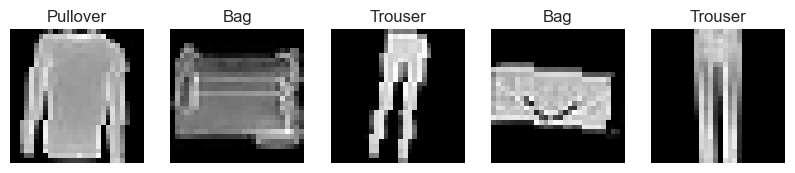

In [41]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(class_names[labels[i]])
    axes[i].axis("off")

plt.show()


## 6. Model Architecture
We define a Convolutional Neural Network with:
- 2 Convolutional Layers (Feature Extraction)
- MaxPooling for dimensionality reduction
- 2 Fully Connected Layers (Classification)
- Dropout to prevent overfitting


In [42]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        # --- Feature extraction ---
        # Input: [Batch, 1, 28, 28]
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=3,
            padding=1
        )
        # Output: [Batch, 32, 28, 28] (padded)

        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        # Output: [Batch, 64, 28, 28]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Reduces spatial dimensions by half (28 -> 14 -> 7)

        # --- Classification ---
        # Flattened size: 64 channels * 7 * 7 = 3136
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10) # 10 classes

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x) # [Batch, 32, 14, 14]

        # Block 2
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x) # [Batch, 64, 7, 7]

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [43]:
model = FashionCNN()

## 8. Training Loop
We use **CrossEntropyLoss** for classification and **Adam** optimizer.
We also use a Learning Rate Scheduler to decay LR every 5 epochs.


In [44]:
# Setup Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.5 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.5
)

num_epochs = 10

train_losses = []
val_losses = []

print("Starting Training...")
for epoch in range(num_epochs):
    # ---- Training Phase ----
    model.train()  # Enable dropout/batchnorm
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()          # Zero gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()                # Backpropagation
        optimizer.step()               # Update weights

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- Validation Phase ----
    model.eval()  # Disable dropout
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    scheduler.step()

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f}"
    )


Epoch [1/10] Train Loss: 0.6678 Val Loss: 0.4106
Epoch [2/10] Train Loss: 0.4625 Val Loss: 0.3452
Epoch [3/10] Train Loss: 0.4071 Val Loss: 0.3139
Epoch [4/10] Train Loss: 0.3760 Val Loss: 0.3112
Epoch [5/10] Train Loss: 0.3512 Val Loss: 0.2915
Epoch [6/10] Train Loss: 0.3192 Val Loss: 0.2640
Epoch [7/10] Train Loss: 0.3062 Val Loss: 0.2672
Epoch [8/10] Train Loss: 0.3004 Val Loss: 0.2609
Epoch [9/10] Train Loss: 0.2909 Val Loss: 0.2506
Epoch [10/10] Train Loss: 0.2843 Val Loss: 0.2518


## 9. Performance Visualization
Plotting the training and validation loss curves.


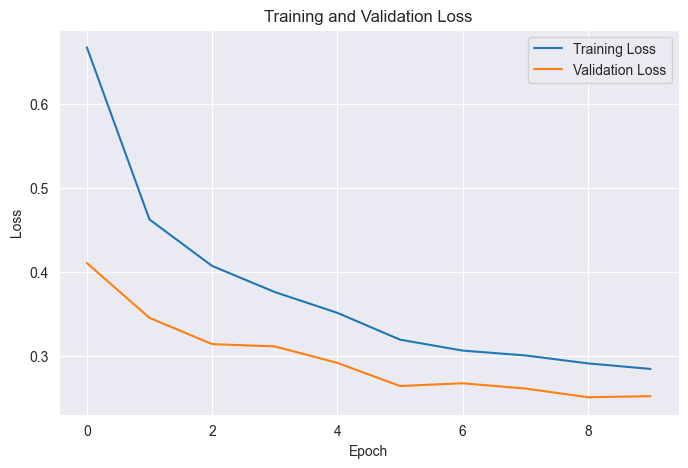

In [45]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

## 10. Evaluation
We compute the accuracy on the test set and plot the Confusion Matrix.


Test Accuracy: 90.99%
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.89      0.87      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.85      0.89      0.87      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.85      0.86      0.86      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.78      0.70      0.74      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



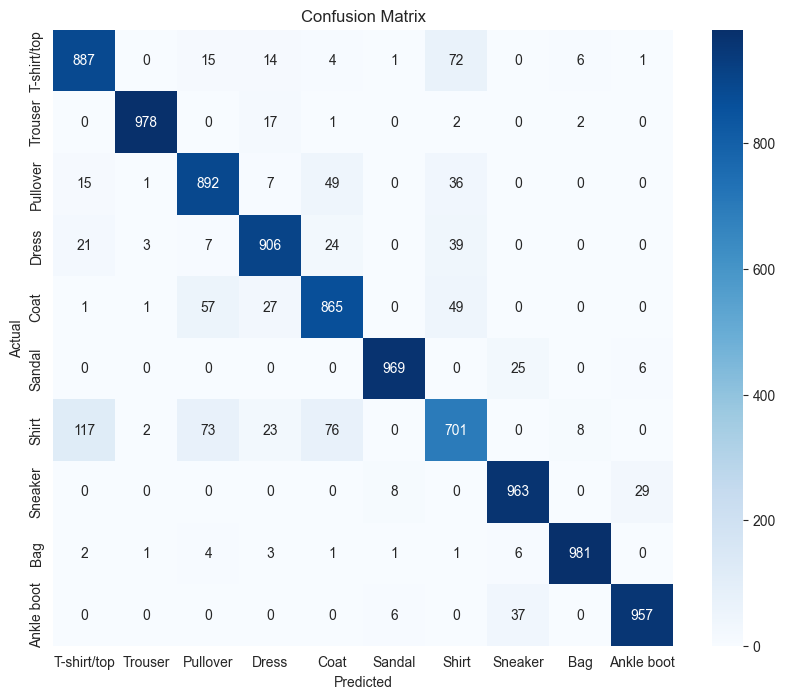

In [46]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print(classification_report(all_labels, all_preds, target_names=class_names))

conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 11. Feature Visualization
We verify that the model has learned useful features by visualizing:
- The learned filters (kernels) of the first convolutional layer.
- The feature maps (activation outputs) for a sample image.


In [47]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()

    # Normalize filters for visualization
    filters = filters - filters.min()
    filters = filters / filters.max()

    num_filters = filters.shape[0]
    n_cols = 8
    n_rows = (num_filters + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    axes = axes.flatten()

    for i in range(num_filters):
        axes[i].imshow(filters[i][0], cmap='gray')
        axes[i].axis('off')

    for i in range(num_filters, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Learned Filters (First Convolutional Layer)")
    plt.show()


In [48]:
def visualize_feature_maps(image, model):
    model.eval()

    with torch.no_grad():
        x = image.unsqueeze(0)          # Add batch dimension
        x = model.conv1(x)
        x = torch.relu(x)

    feature_maps = x.squeeze(0)
    num_maps = feature_maps.shape[0]

    n_cols = 8
    n_rows = (num_maps + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    axes = axes.flatten()

    for i in range(num_maps):
        axes[i].imshow(feature_maps[i], cmap='gray')
        axes[i].axis('off')

    for i in range(num_maps, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Feature Maps After First Convolutional Layer")
    plt.show()


In [49]:
def visualize_deep_feature_maps(image, model):
    model.eval()

    with torch.no_grad():
        x = image.unsqueeze(0)
        x = model.pool(torch.relu(model.conv1(x)))
        x = model.conv2(x)
        x = torch.relu(x)

    feature_maps = x.squeeze(0)
    num_maps = feature_maps.shape[0]

    n_cols = 8
    n_rows = (num_maps + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    axes = axes.flatten()

    for i in range(num_maps):
        axes[i].imshow(feature_maps[i], cmap='gray')
        axes[i].axis('off')

    for i in range(num_maps, len(axes)):
        axes[i].axis('off')

    plt.suptitle("Feature Maps After Second Convolutional Layer")
    plt.show()


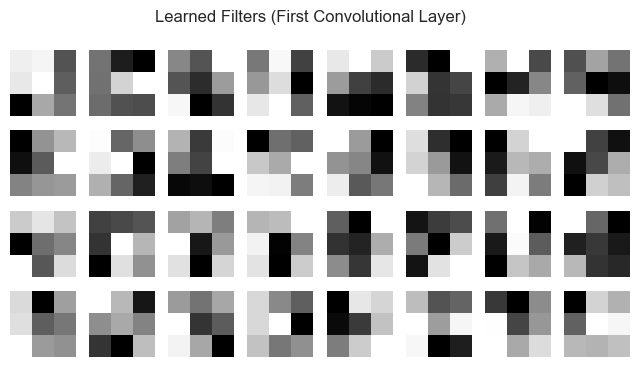

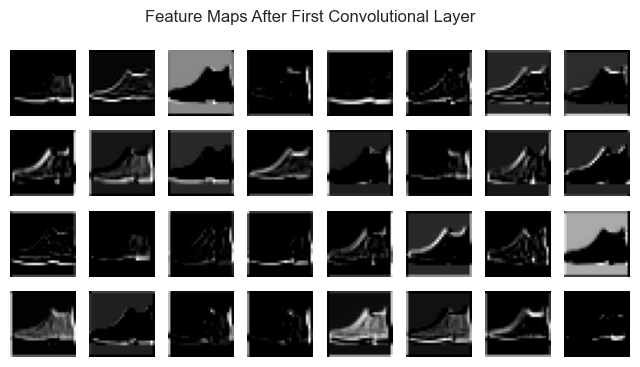

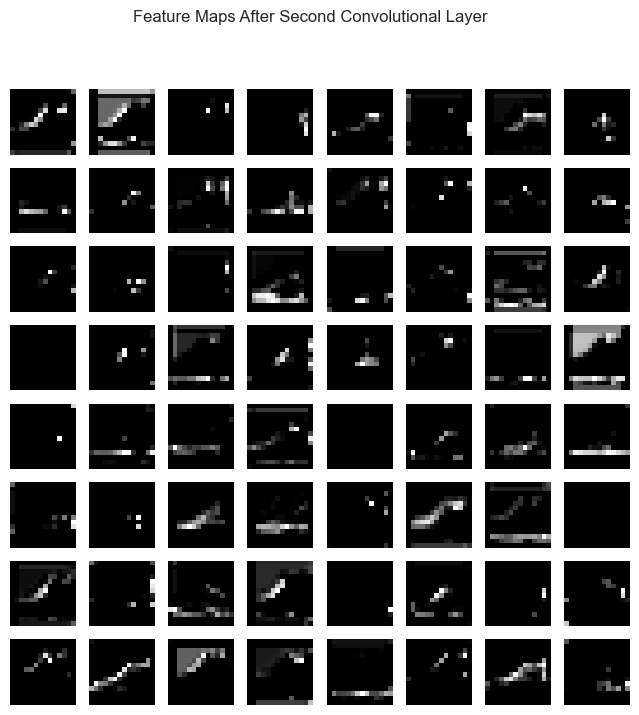

In [50]:
visualize_filters(model.conv1)

sample_image, _ = test_dataset[0]
visualize_feature_maps(sample_image, model)

visualize_deep_feature_maps(sample_image, model)

## 12. Hyperparameter Tuning and Results
In this final phase, we perform the following steps:
1. Define a helper function `run_experiment` to train and evaluate models.
2. Run a set of experiments varying Learning Rate, Dropout, and FC Layer size.
3. Collect and visualize the results in a table.


In [51]:
# ============================
# Phase 7: Hyperparameter Tuning (One-Factor-at-a-Time)
# ============================

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# ---- Baseline hyperparameters ----
BASE_LR = 0.001
BASE_DROPOUT = 0.5
BASE_FC = 128
EPOCHS = 3

# ---- Helper: train + evaluate ----
def run_experiment(lr, dropout, fc_size):
    class TunedCNN(FashionCNN):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(64 * 7 * 7, fc_size)
            self.dropout = nn.Dropout(dropout)
            self.fc2 = nn.Linear(fc_size, 10)

    model = TunedCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training (short run)
    model.train()
    for _ in range(EPOCHS):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100 * correct / total



# ---------------------------------------------------------
# Running Hyperparameter Experiments
# ---------------------------------------------------------
results = []

# ---- 1. Learning Rate Experiment ----
for lr in [0.01, 0.001]:
    acc = run_experiment(lr, BASE_DROPOUT, BASE_FC)
    results.append(["Learning Rate", lr, acc])

# ---- 2. Dropout Experiment ----
for dr in [0.3, 0.5]:
    acc = run_experiment(BASE_LR, dr, BASE_FC)
    results.append(["Dropout", dr, acc])

# ---- 3. Fully Connected Size Experiment ----
for fc in [64, 128]:
    acc = run_experiment(BASE_LR, BASE_DROPOUT, fc)
    results.append(["FC Size", fc, acc])

# ---- Results table ----

# ---------------------------------------------------------
# Analyizing Results
# ---------------------------------------------------------
results_df = pd.DataFrame(
    results,
    columns=["Hyperparameter", "Value", "Test Accuracy (%)"]
)

results_df


Hyperparameter    Value  Test Accuracy (%)
0  Learning Rate    0.010              80.76
1  Learning Rate    0.001              87.96
2        Dropout    0.300              88.92
3        Dropout    0.500              88.97
4        FC Size   64.000              87.58
5        FC Size  128.000              88.30